# Predicción de la demanda

En este notebook vamos a crear un modelo de machine learning para predecir la demanda de vehículos de transporte en función del tiempo (año, mes, dia, hora) y de variables climáticas.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

Importamos la tabla "tlc" que contiene información sobre el número de viajes, agregado por año-mes-dia-hora.

In [2]:
tlc = pd.read_csv("tlc.csv")

tlc.head(1)

,pickup_datehour,num_trips
0,2020-01-01 00:00:00.000000 UTC,56414


Importamos la tabla "weather" que contiene información climática, con el mismo nivel de agregación. Las variables a trabajar fueron seleccionadas previamente a partir del EDA.

In [5]:
weather = pd.read_csv("weather.csv")

weather.head(1)

,date,relative_humidity_2m,apparent_temperature,rain,snowfall,snow_depth,cloud_cover_low,wind_speed_10m,wind_gusts_10m
0,2023-05-16 13:00:00.000000 UTC,14.0,23.0,0.0,0.0,0.0,0.0,23.4,41.4


Mergeamos ambas tablas.

In [6]:
df = tlc.merge(weather, left_on="pickup_datehour", right_on="date", how="left")

df.head(1)

,pickup_datehour,num_trips,date,relative_humidity_2m,apparent_temperature,rain,snowfall,snow_depth,cloud_cover_low,wind_speed_10m,wind_gusts_10m
0,2020-01-01 00:00:00.000000 UTC,56414,2020-01-01 00:00:00.000000 UTC,74.0,-1.8,0.0,0.0,0.0,0.0,17.7,29.2


In [8]:
# Eliminar la columna date
df.drop(columns=['date'], inplace=True)

df.head(1)

,pickup_datehour,num_trips,relative_humidity_2m,apparent_temperature,rain,snowfall,snow_depth,cloud_cover_low,wind_speed_10m,wind_gusts_10m
0,2020-01-01 00:00:00.000000 UTC,56414,74.0,-1.8,0.0,0.0,0.0,0.0,17.7,29.2


In [9]:
# Convierte la columna 'pickup_datehour' a formato de fecha y hora
df['pickup_datehour'] = pd.to_datetime(df['pickup_datehour'])

# Crea una nueva columna 'day_of_week' que contiene el día de la semana en texto
df['day_of_week'] = df['pickup_datehour'].dt.day_name()

# Extrae las columnas de año, mes y hora
df['year'] = df['pickup_datehour'].dt.year
df['month'] = df['pickup_datehour'].dt.month
df['day'] = df['pickup_datehour'].dt.day
df['hour'] = df['pickup_datehour'].dt.hour

df.head(1)

,pickup_datehour,num_trips,relative_humidity_2m,apparent_temperature,rain,snowfall,snow_depth,cloud_cover_low,wind_speed_10m,wind_gusts_10m,day_of_week,year,month,day,hour
0,2020-01-01 00:00:00+00:00,56414,74.0,-1.8,0.0,0.0,0.0,0.0,17.7,29.2,Wednesday,2020,1,1,0


Visualicemos los viajes según el año y mes.

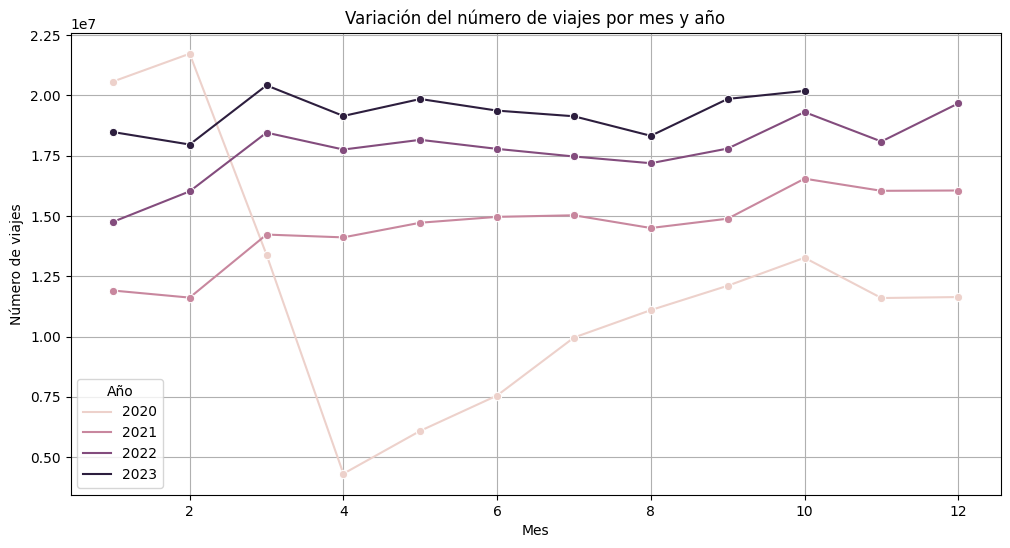

In [10]:
# Agrupar por año y mes, y sumar el número de viajes
df_grouped = df.groupby(["year", "month"]).num_trips.sum().reset_index()

# Crear un gráfico de líneas utilizando seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='num_trips', hue='year', data=df_grouped, marker='o')

# Personalizar el gráfico
plt.title('Variación del número de viajes por mes y año')
plt.xlabel('Mes')
plt.ylabel('Número de viajes')
plt.legend(title='Año')
plt.grid(True)
plt.show()

Vemos que el 2020 sigue una tendencia distinta a los otros años. Esto se debe probablemente a la pandemia por lo que descartaremos este año de nuestro modelo.

In [11]:
df = df[df.year > 2020]

In [12]:
# Convierte 'day_of_week' a one-hot encoding
df = pd.get_dummies(df, columns=['day_of_week'], prefix='', prefix_sep='').astype("int")

In [13]:
df.drop(columns=["pickup_datehour"], inplace=True)

df.head(1)

,num_trips,relative_humidity_2m,apparent_temperature,rain,snowfall,snow_depth,cloud_cover_low,wind_speed_10m,wind_gusts_10m,year,month,day,hour,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
8775,30381,71,-5,0,0,0,0,10,18,2021,1,1,0,1,0,0,0,0,0,0


Haremos un primer modelo para ver cuales son las variables mas importantes.

In [14]:
# Selecciona las características (X) y la variable objetivo (y)
X = df.drop(['num_trips'], axis=1)  # Excluye la variable objetivo
y = df['num_trips']

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crea un modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo con cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_mse = -cv_scores.mean()

# Entrenar el modelo final con los datos de entrenamiento
rf_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = rf_model.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Cross-Validated Mean Squared Error: {cv_mse}')
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

Cross-Validated Mean Squared Error: 4884644.855555859
Mean Squared Error: 5332846.921860253
R2 Score: 0.9490367399771271


Veamos la importancia de las características.

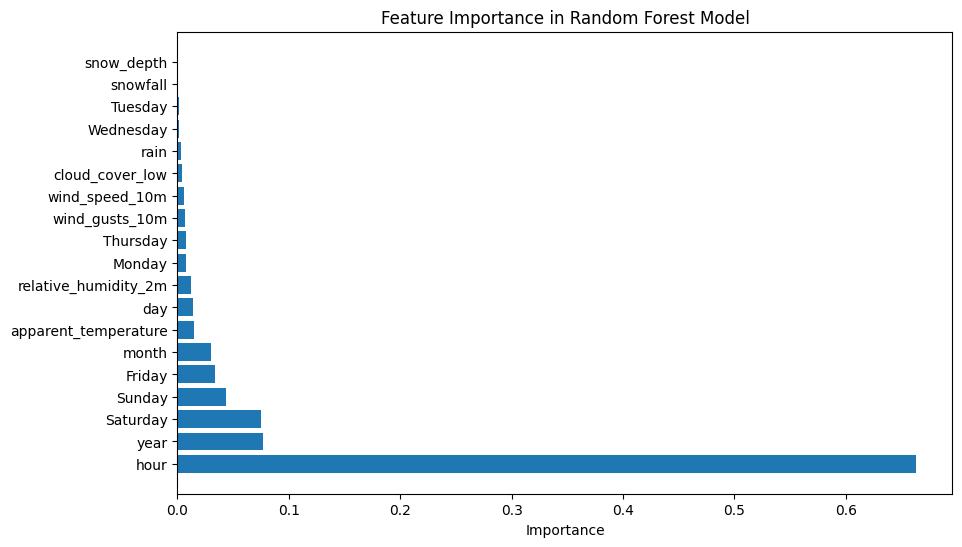

In [15]:
# Obtiene la importancia de las características
feature_importance = rf_model.feature_importances_

# Crea un DataFrame para visualizar la importancia de las características
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Ordena el DataFrame por importancia en orden descendente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualiza la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.show()

Vemos que el atributo más importante para explicar el número de viajes es la hora del dia, seguida del año y dias del fin de semana. Entre las variables climáticas que más contribuyen a explicar el target, están la temperatura aparente y la humedad relativa a 2m, por lo que conservaremos las mismas para el modelo de ML.

Busquemos ahora el modelo con los mejores hiperparámetros para estos atributos.

In [16]:
X = df.drop(['num_trips','snow_depth', 'snowfall', 'rain', 'cloud_cover_low',
             'wind_speed_10m', 'wind_gusts_10m'], axis=1)
y = df['num_trips']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [17]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Error cuadrático medio en conjunto de prueba: {mse}")

Error cuadrático medio en conjunto de prueba: 5172561.393040507


In [18]:
from math import sqrt
rmse = sqrt(mse)
rmse

2274.3265801200378

In [19]:
r2_score(y_test, y_pred)

0.9505685058805622